In [32]:
import os
import socket
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, length, when, col, broadcast
from pyspark.sql.window import Window
from pyspark.sql.types import BooleanType, IntegerType, LongType, StringType, ArrayType, FloatType, StructType, StructField
from pyspark.sql.functions import pandas_udf
from pyspark.sql.functions import PandasUDFType
from pyspark import StorageLevel
from jinja2 import Environment, FileSystemLoader
import matplotlib.pyplot as plt
import datetime

In [3]:
# setting constants
APP_NAME = "COURSE_WORK"
NORMALIZED_APP_NAME = APP_NAME.replace('/', '_').replace(':', '_')

APPS_TMP_DIR = os.path.join(os.getcwd(), "tmp")
APPS_CONF_DIR = os.path.join(os.getcwd(), "conf")
APPS_LOGS_DIR = os.path.join(os.getcwd(), "logs")
LOG4J_PROP_FILE = os.path.join(APPS_CONF_DIR, "pyspark-log4j-{}.properties".format(NORMALIZED_APP_NAME))
LOG_FILE = os.path.join(APPS_LOGS_DIR, 'pyspark-{}.log'.format(NORMALIZED_APP_NAME))
EXTRA_JAVA_OPTIONS = "-Dlog4j.configuration=file://{} -Dspark.hadoop.dfs.replication=1 -Dhttps.protocols=TLSv1.0,TLSv1.1,TLSv1.2,TLSv1.3"\
    .format(LOG4J_PROP_FILE)

LOCAL_IP = socket.gethostbyname(socket.gethostname())

In [4]:
# preparing configuration files from templates
for directory in [APPS_CONF_DIR, APPS_LOGS_DIR, APPS_TMP_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

env = Environment(loader=FileSystemLoader('/opt'))
template = env.get_template("pyspark_log4j.properties.template")
template\
    .stream(logfile=LOG_FILE)\
    .dump(LOG4J_PROP_FILE)

In [5]:
# run spark
spark = SparkSession\
    .builder\
    .appName(APP_NAME)\
    .master("k8s://https://10.32.7.103:6443")\
    .config("spark.driver.host", LOCAL_IP)\
    .config("spark.ui.port", "4040")\
    .config("spark.kubernetes.memoryOverheadFactor", "0.6")\
    .config("spark.driver.memory", "4g")\
    .config("spark.driver.bindAddress", "0.0.0.0")\
    .config("spark.executor.instances", "5")\
    .config("spark.executor.cores", '4')\
    .config("spark.executor.memory", "5g")\
    .config("spark.memory.fraction", "0.6")\
    .config("spark.memory.storageFraction", "0.5")\
    .config("spark.sql.autoBroadcastJoinThreshold", "-1")\
    .config("spark.driver.extraJavaOptions", EXTRA_JAVA_OPTIONS)\
    .config("spark.kubernetes.namespace", "refremov-225111")\
    .config("spark.kubernetes.driver.label.appname", APP_NAME)\
    .config("spark.kubernetes.executor.label.appname", APP_NAME)\
    .config("spark.kubernetes.container.image.pullPolicy", "Always")\
    .config("spark.kubernetes.container.image", "node03.st:5000/spark-executor:refremov-225111")\
    .config("spark.kubernetes.executor.deleteOnTermination", "true")\
    .config("spark.local.dir", "/tmp/spark")\
    .getOrCreate()

In [6]:
print("Web UI: {}".format(spark.sparkContext.uiWebUrl))
print("\nlog4j file: {}".format(LOG4J_PROP_FILE))
print("\ndriver log file: {}".format(LOG_FILE))

Web UI: http://10.128.75.244:4040

log4j file: /home/jovyan/work/conf/pyspark-log4j-COURSE_WORK.properties

driver log file: /home/jovyan/work/logs/pyspark-COURSE_WORK.log


# Read and clean dataset

In [18]:
JSON_SCHEMA = StructType([
    StructField('_id', StructType([
        StructField('$oid', StringType())
    ])),
    StructField('x', IntegerType()),
    StructField('y', IntegerType()),
    StructField('z', IntegerType()),
    StructField('time_detected', FloatType()),
    StructField('object_id', IntegerType()),
    StructField('category', StringType()),
    StructField('clf_category', StringType()),
    StructField('conf', FloatType()),
    StructField('picked', BooleanType()),
    StructField('proceed', StructType([
        StructField('proceed_1', StringType()),
        StructField('proceed_2', StringType()),
    ])),
    StructField('repeated_detection', ArrayType(StructType([
        StructField('time_detected', FloatType()),
        StructField('x', IntegerType()),
        StructField('y', IntegerType()),
        StructField('z', IntegerType()),
        StructField('category', StringType()),
        StructField('clf_category', StringType()),
        StructField('conf', FloatType())
    ])))
])
df = spark.read.json('/home/refremov-225111/detect_12.json', multiLine=True, schema=JSON_SCHEMA)

In [8]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- x: integer (nullable = true)
 |-- y: integer (nullable = true)
 |-- z: integer (nullable = true)
 |-- time_detected: float (nullable = true)
 |-- object_id: integer (nullable = true)
 |-- category: string (nullable = true)
 |-- clf_category: string (nullable = true)
 |-- conf: float (nullable = true)
 |-- picked: boolean (nullable = true)
 |-- proceed: struct (nullable = true)
 |    |-- proceed_1: string (nullable = true)
 |    |-- proceed_2: string (nullable = true)
 |-- repeated_detection: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- time_detected: float (nullable = true)
 |    |    |-- x: integer (nullable = true)
 |    |    |-- y: integer (nullable = true)
 |    |    |-- z: integer (nullable = true)
 |    |    |-- category: string (nullable = true)
 |    |    |-- clf_category: string (nullable = true)
 |    |    |-- conf: float (nullable = true)



In [9]:
df.count()

640258

In [19]:
df = df.withColumn("py_date", F.from_unixtime("time_detected")).drop("time_detected")

In [20]:
df.select("clf_category").distinct().show()

+------------+
|clf_category|
+------------+
|        none|
+------------+



In [21]:
df = df.drop("clf_category")

In [22]:
df = df.drop("object_id")

# Brief analyze

Min and max confedence for picked and not picked objects.

In [23]:
df.where("picked = true").agg(F.min("conf"), F.max("conf")).show()

+---------+---------+
|min(conf)|max(conf)|
+---------+---------+
|0.5004883|0.9550781|
+---------+---------+



In [24]:
df.where("picked = false").agg(F.min("conf"), F.max("conf")).show()

+---------+---------+
|min(conf)|max(conf)|
+---------+---------+
|0.5004883|0.9716797|
+---------+---------+



Top categories of picked and not picked objects.

In [25]:
df.where("picked = true").groupBy("category").count().show()

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         BLUE BOTTLE|20899|
|     DETERGENT WHITE| 1928|
|         MILK BOTTLE| 2001|
|         DARK BOTTLE| 3750|
|       DETERGENT BOX|  162|
|           5L BOTTLE| 2036|
|     DETERGENT COLOR| 1430|
|       TRANSP BOTTLE|28093|
|        GREEN BOTTLE| 9635|
|DETERGENT TRANSPA...| 1581|
+--------------------+-----+



In [26]:
df.where("picked = false").groupBy("category").count().show()

+--------------------+------+
|            category| count|
+--------------------+------+
|         BLUE BOTTLE| 87877|
|        GLASS TRANSP| 28796|
|            CANISTER|   149|
|         GLASS GREEN| 10398|
|     DETERGENT WHITE|  3513|
|         MILK BOTTLE|  4599|
|              YOGURT| 16825|
|         DARK BOTTLE|  9156|
|       DETERGENT BOX|   279|
|           5L BOTTLE| 18635|
|                CANS|166175|
|     DETERGENT COLOR|  2409|
|          GLASS DARK| 12892|
|     JUICE CARDBOARD| 34560|
|       TRANSP BOTTLE| 73037|
|      MILK CARDBOARD| 60024|
|        GREEN BOTTLE| 28566|
|DETERGENT TRANSPA...|  3314|
|          OIL BOTTLE|  6588|
|   MULTICOLOR BOTTLE|   951|
+--------------------+------+



In [27]:
df.agg(F.min("x"), F.max("x"), F.min("y"), F.max("y"), F.min("z"), F.max("z"), F.min("py_date"), F.max("py_date")).show()

+------+------+------+------+------+------+-------------------+-------------------+
|min(x)|max(x)|min(y)|max(y)|min(z)|max(z)|       min(py_date)|       max(py_date)|
+------+------+------+------+------+------+-------------------+-------------------+
|   151|  1150|   108|   612|  -150|  -110|2021-05-15 16:29:52|2021-06-08 11:05:36|
+------+------+------+------+------+------+-------------------+-------------------+



In [28]:
df.groupby("category").agg(F.min("conf").alias("min_conf"))\
    .orderBy(F.desc("min_conf"))\
    .limit(10)\
    .show()

+-----------------+----------+
|         category|  min_conf|
+-----------------+----------+
|MULTICOLOR BOTTLE|0.50146484|
|      BLUE BOTTLE| 0.5004883|
|     GLASS TRANSP| 0.5004883|
|         CANISTER| 0.5004883|
|      GLASS GREEN| 0.5004883|
|  DETERGENT WHITE| 0.5004883|
|      MILK BOTTLE| 0.5004883|
|           YOGURT| 0.5004883|
|      DARK BOTTLE| 0.5004883|
|    DETERGENT BOX| 0.5004883|
+-----------------+----------+



In [29]:
df.groupby("category").agg(F.max("conf").alias("max_conf"))\
    .orderBy(F.desc("max_conf"))\
    .limit(10)\
    .show()

+--------------------+----------+
|            category|  max_conf|
+--------------------+----------+
|              YOGURT| 0.9716797|
|     DETERGENT WHITE|0.96533203|
|          OIL BOTTLE| 0.9604492|
|DETERGENT TRANSPA...| 0.9589844|
|     JUICE CARDBOARD| 0.9560547|
|       DETERGENT BOX| 0.9550781|
|        GREEN BOTTLE|0.95458984|
|     DETERGENT COLOR| 0.9536133|
|         BLUE BOTTLE|0.95214844|
|      MILK CARDBOARD|0.95166016|
+--------------------+----------+



In [30]:
df.groupby("category").agg(F.avg("conf").alias("avg_conf"))\
    .orderBy(F.desc("avg_conf"))\
    .limit(10)\
    .show()

+---------------+------------------+
|       category|          avg_conf|
+---------------+------------------+
|      5L BOTTLE|0.8046469890259905|
|   GREEN BOTTLE|0.6951201707947763|
|    BLUE BOTTLE|0.6911025106569348|
|  TRANSP BOTTLE|0.6875883473777563|
|JUICE CARDBOARD|0.6788801970305266|
|DETERGENT WHITE|0.6751953304482172|
|    MILK BOTTLE|0.6714120205965909|
|  DETERGENT BOX|0.6707943594104309|
|     OIL BOTTLE|0.6641825691598361|
|   GLASS TRANSP|0.6634722928368958|
+---------------+------------------+



# Count of picked objects by day

In [34]:
day_count = df.withColumn("day", F.date_format("py_date", "yyyy/MM/dd"))\
    .groupby("day").agg(F.count("*").alias("count"))\
    .orderBy("day").toPandas()
day_count.head()

,day,count
0,2021/05/15,19928
1,2021/05/16,51463
2,2021/05/17,29477
3,2021/05/18,14308
4,2021/05/19,25178


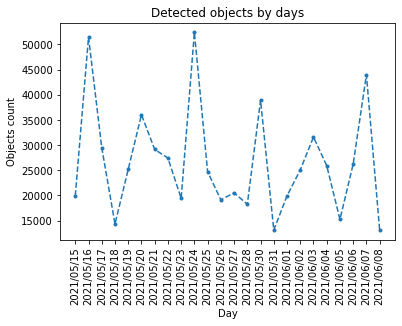

In [35]:
plt.plot(day_count['day'], day_count['count'], '.--');
plt.xticks(rotation=90);
plt.title('Detected objects by days');
plt.xlabel('Day');
plt.ylabel('Objects count');

In [36]:
df_with_days = df.withColumn("day", F.date_format("py_date", "yyyy/MM/dd"))
days_picked_count = df_with_days.where("picked = true")\
    .groupby("day").agg(F.count("*").alias("picked_count"))\
    .orderBy("day").toPandas()
days_picked_count.head()

,day,picked_count
0,2021/05/15,2972
1,2021/05/16,6133
2,2021/05/17,4344
3,2021/05/18,2734
4,2021/05/19,3032


In [37]:
merged_df = days_picked_count.merge(day_count, how="inner", left_on="day", right_on="day")
merged_df.head()

,day,picked_count,count
0,2021/05/15,2972,19928
1,2021/05/16,6133,51463
2,2021/05/17,4344,29477
3,2021/05/18,2734,14308
4,2021/05/19,3032,25178


In [38]:
merged_df['percent_picked'] = merged_df['picked_count'] / merged_df['count'] * 100

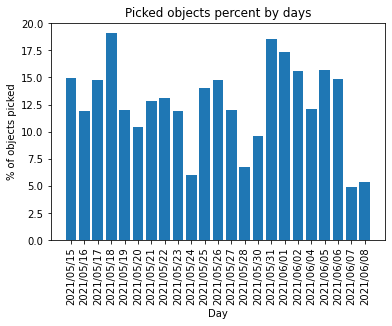

In [42]:
plt.bar(merged_df['day'], merged_df['percent_picked']);
plt.xticks(rotation=90);
plt.title('Picked objects percent by days');
plt.xlabel('Day');
plt.ylabel('% of objects picked');

# Time intervals

In [43]:
sorted_dates_df = df.select("py_date").orderBy("py_date")

In [44]:
time_detected_diffs = sorted_dates_df\
    .withColumn("prev_py_date", 
                F.lag("py_date").over(Window.orderBy("py_date")))\
    .where('prev_py_date is not null')\
    .withColumn("diff", F.unix_timestamp("py_date") - 
                    F.unix_timestamp("prev_py_date"))\
    .groupby("diff").agg(F.count("*").alias("count"))\
    .orderBy("diff")\
    .toPandas()

In [50]:
time_detected_diffs_pick = sorted_dates_df\
    .where("picked = true")\
    .withColumn("prev_py_date", 
                F.lag("py_date").over(Window.orderBy("py_date")))\
    .where('prev_py_date is not null')\
    .withColumn("diff", F.unix_timestamp("py_date") - 
                    F.unix_timestamp("prev_py_date"))\
    .groupby("diff").agg(F.count("*").alias("count"))\
    .orderBy("diff")\
    .toPandas()

In [51]:
import numpy as np

In [62]:
time_detected_diffs['diff'].median(),\
    time_detected_diffs['diff'].min(),\
    time_detected_diffs['diff'].max()

(2816.0, 0, 133376)

In [63]:
time_detected_diffs_pick['diff'].median(),\
    time_detected_diffs_pick['diff'].min(),\
    time_detected_diffs_pick['diff'].max()

(3648.0, 0, 133376)

Why so big intervals? May be robot does not work in some hours? At which days and hours there are biggest gaps?

Top 10 gaps

In [67]:
sorted_dates_df\
    .withColumn("prev_py_date", 
                F.lag("py_date").over(Window.orderBy("py_date")))\
    .where('prev_py_date is not null')\
    .withColumn("diff", F.unix_timestamp("py_date") - 
                    F.unix_timestamp("prev_py_date"))\
    .orderBy(F.desc("diff"))\
    .select("prev_py_date", "py_date", "diff")\
    .show(10)

+-------------------+-------------------+------+
|       prev_py_date|            py_date|  diff|
+-------------------+-------------------+------+
|2021-05-28 17:27:28|2021-05-30 06:30:24|133376|
|2021-05-31 12:37:20|2021-06-01 05:28:32| 60672|
|2021-05-18 04:07:28|2021-05-18 11:07:44| 25216|
|2021-05-19 02:14:24|2021-05-19 07:00:16| 17152|
|2021-05-17 10:40:00|2021-05-17 14:32:32| 13952|
|2021-06-02 10:20:48|2021-06-02 13:11:28| 10240|
|2021-05-28 05:41:20|2021-05-28 08:32:00| 10240|
|2021-06-01 08:51:12|2021-06-01 11:01:20|  7808|
|2021-05-18 02:01:36|2021-05-18 03:46:08|  6272|
|2021-05-26 04:52:16|2021-05-26 06:28:16|  5760|
+-------------------+-------------------+------+
only showing top 10 rows



# Pie char for categories count

In [54]:
category_counts = df.groupBy("category").count().toPandas()

In [55]:
category_counts = category_counts.sort_values(["count"], ascending=False)

In [56]:
category_counts_subset = category_counts[:14]

In [57]:
category_counts_other = category_counts[14:]["count"].sum()
category_counts_other

15716

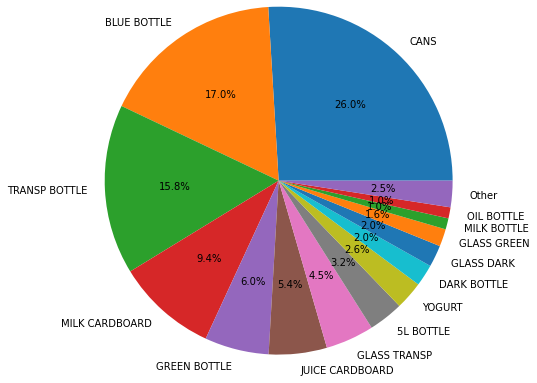

In [58]:
plt.pie(list(category_counts_subset['count']) + [category_counts_other], autopct='%1.1f%%',
        labels=list(category_counts_subset['category']) + ['Other'], radius=2);

# Check why robot doesn't pick objects

In [80]:
df_not_picked = df.where("picked = false")\
    .select(col("_id.$oid").alias("id"), "py_date", "x", "y", "z")

df_picked = df.where("picked = true")\
    .select(col("_id.$oid").alias("id"), "py_date", "x", "y", "z")

In [ ]:
nearest_pd_df = df_not_picked.alias("df_not_picked")\
    .join(df_picked.alias("df_picked"), 
          col("df_picked.py_date") <= col("df_not_picked.py_date"),
          how = "left_outer")\
    .withColumn("date_diff", 
                F.unix_timestamp("df_not_picked.py_date") - F.unix_timestamp("df_picked.py_date"))\
    .withColumn("coord_diff", F.abs(col("df_picked.x") - col("df_not_picked.x")) +
                F.abs(col("df_picked.y") - col("df_not_picked.y")) + 
                F.abs(col("df_picked.z") - col("df_not_picked.z")))\
    .where("df_picked.id is not null")\
    .groupBy("df_not_picked.id").agg(F.min(F.struct("date_diff", "coord_diff")).alias("nearest"))\
    .toPandas()

In [ ]:
nearest_pd_df.head()

# End

In [115]:
spark.stop()